### In this model, I am using the provided classification dataset, and VGGFace model to build my face classification model

# Import

In [1]:
!pip install opencv-python-headless

In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import random
import shutil

from google.colab import drive

from tensorflow.keras.models import Model

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Data Loading

## Setup Path

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Unzip the Dataset
zip_file_path = '/content/drive/MyDrive/AML/classification_data.zip'
extract_dir = '/content'
!unzip -q "$zip_file_path" -d "$extract_dir"
!ls "$extract_dir"

Mounted at /content/drive
classification_data  drive  __MACOSX  sample_data


In [5]:
# Define the file paths for train, validation, and test data
TRAIN_PATH = os.path.join(extract_dir, 'classification_data', 'train_data')
VAL_PATH = os.path.join(extract_dir, 'classification_data', 'val_data')
TEST_PATH = os.path.join(extract_dir, 'classification_data', 'test_data')

In [6]:
TRAIN_PATH

'/content/classification_data/train_data'

## Use SSD to detect face in that image, avoid noisy data and background

In [ ]:
# Load SSD face detector model
prototxt_path = '/content/deploy.prototxt'
caffemodel_path = '/content/res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

# Function to detect faces using SSD
def detect_faces_ssd(image, conf_threshold=0.5):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            faces.append((startX, startY, endX, endY))
    return faces

## Due to limited computational power, only 500 out of 3000 classes are selected, under condition where SSD are able to detect at least 30 faces in each class

In [ ]:
# Function to select classes based on the number of detected faces using SSD
def select_classes_with_faces(data_path, min_images=20):
    selected_classes = []
    for class_dir in os.listdir(data_path):
        class_path = os.path.join(data_path, class_dir)
        if os.path.isdir(class_path):
            face_count = 0
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path) and file_name.lower().endswith(('.jpg')):
                    img = cv2.imread(file_path)
                    faces = detect_faces_ssd(img)
                    if len(faces) > 0:
                        face_count += 1
                if face_count >= min_images:
                    selected_classes.append(class_dir)
                    break
    return selected_classes

# Select classes with at least 30 images with detected faces from the train dataset
train_classes_with_faces = select_classes_with_faces(TRAIN_PATH, min_images=30)

# Randomly select 500 classes to keep
selected_classes = random.sample(train_classes_with_faces, 500)

In [ ]:
# Function to remove unselected classes from a dataset
def remove_unselected_classes(data_path, selected_classes):
    for class_dir in os.listdir(data_path):
        class_path = os.path.join(data_path, class_dir)
        if os.path.isdir(class_path) and class_dir not in selected_classes:
            shutil.rmtree(class_path)

remove_unselected_classes(TRAIN_PATH, selected_classes)
remove_unselected_classes(VAL_PATH, selected_classes)
remove_unselected_classes(TEST_PATH, selected_classes)

In [ ]:
# Rename directories and files
def rename_directories_and_files(base_path, selected_classes):
    for idx, dir_name in enumerate(sorted(selected_classes)):
        new_dir_name = f"{idx + 1:04d}"
        old_dir_path = os.path.join(base_path, dir_name)
        new_dir_path = os.path.join(base_path, new_dir_name)
        os.rename(old_dir_path, new_dir_path)
        file_list = sorted([f for f in os.listdir(new_dir_path) if os.path.isfile(os.path.join(new_dir_path, f))])
        for file_idx, file_name in enumerate(file_list):
            old_file_path = os.path.join(new_dir_path, file_name)
            new_file_name = f"{file_idx + 1:02d}.jpg"
            new_file_path = os.path.join(new_dir_path, new_file_name)
            if not file_name.lower().endswith('.jpg'):
                os.remove(old_file_path)
            else:
                os.rename(old_file_path, new_file_path)

rename_directories_and_files(TRAIN_PATH, selected_classes)
rename_directories_and_files(VAL_PATH, selected_classes)
rename_directories_and_files(TEST_PATH, selected_classes)


In [ ]:
# Count the number of classes in each dataset
def count_classes(data_path):
    return len([name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))])

train_class_count = count_classes(TRAIN_PATH)
val_class_count = count_classes(VAL_PATH)
test_class_count = count_classes(TEST_PATH)
print(f"Train dataset has {train_class_count} classes")
print(f"Validation dataset has {val_class_count} classes")
print(f"Test dataset has {test_class_count} classes")

Train dataset has 500 classes
Validation dataset has 500 classes
Test dataset has 500 classes


# Define VGGFace



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
model = vgg_face()

model.load_weights('/content/drive/MyDrive/AML/vgg_face_weights.h5')

In [ ]:
model.layers[0], model.layers[-2]

(<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D at 0x7ccd49878040>,
 <keras.src.layers.reshaping.flatten.Flatten at 0x7ccd411494e0>)

In [ ]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
type(vgg_face_descriptor)

keras.src.engine.functional.Functional

In [ ]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float16 (created by layer 'flatten')>])

# Generate Embedding using VGGFace

In [ ]:
# Function to generate embeddings for each image
def generate_embeddings(data_path, model, label_map, target_size=(224, 224)):
    embeddings = []
    labels = []
    for class_dir in os.listdir(data_path):
        class_path = os.path.join(data_path, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(file_path)
                    img = cv2.resize(img, target_size)
                    img = (img / 255.).astype(np.float32)
                    embedding_vector = model.predict(np.expand_dims(img, axis=0))[0]
                    embeddings.append(embedding_vector)
                    labels.append(label_map[class_dir])
    return np.array(embeddings), np.array(labels)

# Update label map creation
label_map = {class_name: idx for idx, class_name in enumerate(sorted(os.listdir(TRAIN_PATH)))}

# Generate embeddings for train, validation, and test datasets
X_train, y_train = generate_embeddings(TRAIN_PATH, vgg_face_descriptor, label_map)
X_val, y_val = generate_embeddings(VAL_PATH, vgg_face_descriptor, label_map)
X_test, y_test = generate_embeddings(TEST_PATH, vgg_face_descriptor, label_map)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step


In [ ]:
# Save embeddings and labels
def save_embeddings(embeddings, labels, embedding_file, label_file):
    np.save(embedding_file, embeddings)
    np.save(label_file, labels)

# Save train embeddings and labels
save_embeddings(X_train, y_train, '/content/drive/MyDrive/AML/X_train_embeddings.npy', '/content/drive/MyDrive/AML/y_train_labels.npy')
# Save validation embeddings and labels
save_embeddings(X_val, y_val, '/content/drive/MyDrive/AML/X_val_embeddings.npy', '/content/drive/MyDrive/AML/y_val_labels.npy')
# Save test embeddings and labels
save_embeddings(X_test, y_test, '/content/drive/MyDrive/AML/X_test_embeddings.npy', '/content/drive/MyDrive/AML/y_test_labels.npy')

# Save the label map
np.save('/content/drive/MyDrive/AML/label_map.npy', label_map)


In [10]:
# load saved embeddings
# Load embeddings and labels
def load_embeddings(embedding_file, label_file):
    embeddings = np.load(embedding_file)
    labels = np.load(label_file)
    return embeddings, labels

# Load train embeddings and labels
X_train, y_train = load_embeddings('/content/drive/MyDrive/AML/X_train_embeddings.npy', '/content/drive/MyDrive/AML/y_train_labels.npy')
# Load validation embeddings and labels
X_val, y_val = load_embeddings('/content/drive/MyDrive/AML/X_val_embeddings.npy', '/content/drive/MyDrive/AML/y_val_labels.npy')
# Load test embeddings and labels
X_test, y_test = load_embeddings('/content/drive/MyDrive/AML/X_test_embeddings.npy', '/content/drive/MyDrive/AML/y_test_labels.npy')

# Load the label map
label_map = np.load('/content/drive/MyDrive/AML/label_map.npy', allow_pickle=True).item()

In [11]:
# Encode the targets, label change to int
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Standardize the feature values, standardizes the feature values (embeddings) to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

# Reduce dimensions using PCA
# reduce the dimensionality of the data while retaining most of the variance in the dataset
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)

# Train SVM Classifier

In [9]:
# Train an SVM classifier
clf = SVC(C=5.0, gamma=0.001, probability=True)
clf.fit(X_train_pca, y_train_encoded)

# Make predictions
y_train_predict = clf.predict(X_train_pca)
y_val_predict = clf.predict(X_val_pca)
y_test_predict = clf.predict(X_test_pca)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_encoded, y_train_predict)
val_accuracy = accuracy_score(y_val_encoded, y_val_predict)
test_accuracy = accuracy_score(y_test_encoded, y_test_predict)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 99.90%
Validation Accuracy: 71.30%
Test Accuracy: 68.50%


In [10]:
import joblib

# Save the classifier and other components
save_path = '/content/drive/MyDrive/AML/'
joblib.dump(clf, os.path.join(save_path, 'classifierVGG.pkl'))
joblib.dump(pca, os.path.join(save_path, 'pca.pkl'))
joblib.dump(scaler, os.path.join(save_path, 'scaler.pkl'))
joblib.dump(le, os.path.join(save_path, 'label_encoder.pkl'))

['/content/drive/MyDrive/AML/label_encoder.pkl']

# Evaluation

In [12]:
# Load trained model
import joblib

# Load the saved components
load_path = '/content/drive/MyDrive/AML/'
clf = joblib.load(os.path.join(load_path, 'classifierVGG.pkl'))
pca = joblib.load(os.path.join(load_path, 'pca.pkl'))
scaler = joblib.load(os.path.join(load_path, 'scaler.pkl'))
le = joblib.load(os.path.join(load_path, 'label_encoder.pkl'))

# Standardize and reduce dimensions using the loaded scaler and PCA
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

# Encode the labels
y_test_encoded = le.transform(y_test)

# Make predictions
y_test_prob = clf.predict_proba(X_test_pca)
y_test_predict = clf.predict(X_test_pca)

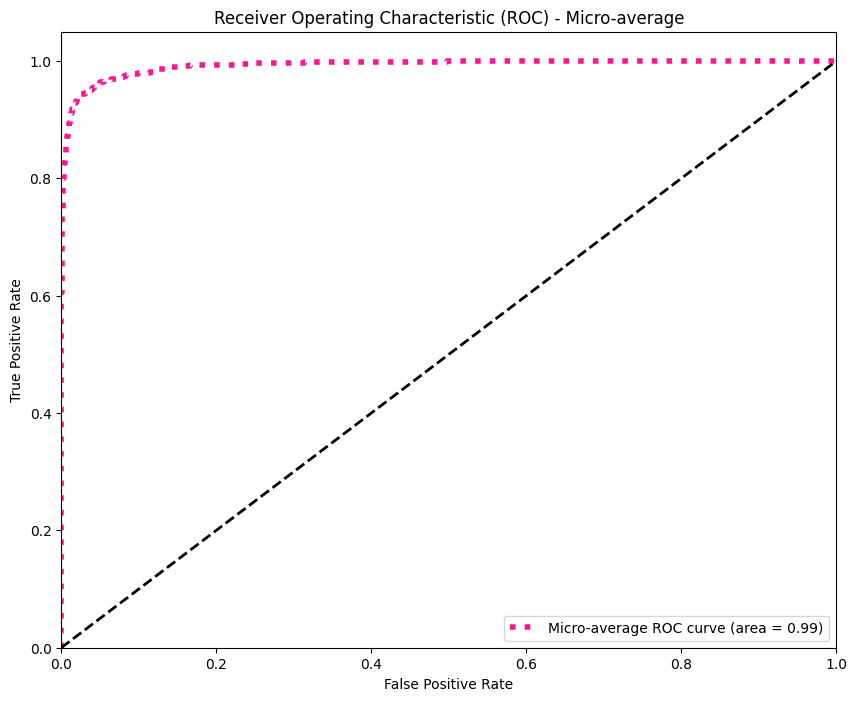

Micro-average ROC AUC: 0.99


In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test_encoded, classes=np.arange(len(le.classes_)))

# Get the probabilities
y_test_prob = clf.predict_proba(X_test_pca)

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_test_prob.ravel())
roc_auc = auc(fpr, tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='deeppink', linestyle=':', linewidth=4,
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Micro-average')
plt.legend(loc="lower right")
plt.show()

print(f"Micro-average ROC AUC: {roc_auc:.2f}")